In [49]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [51]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


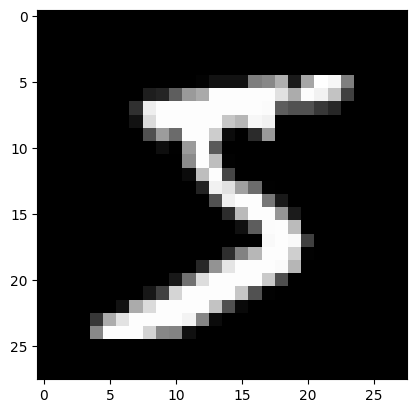

In [52]:
plt.imshow(X=x_train[0], cmap='gray')

In [53]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
print(x_train.shape)

(60000, 28, 28)


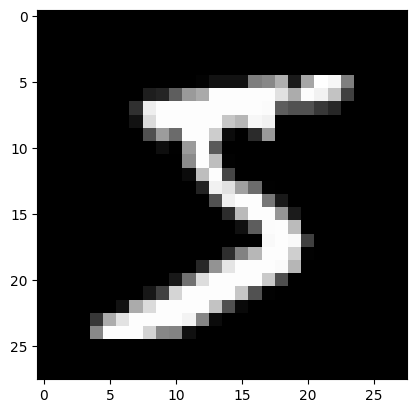

In [54]:
plt.imshow(X=x_train[0], cmap='gray')

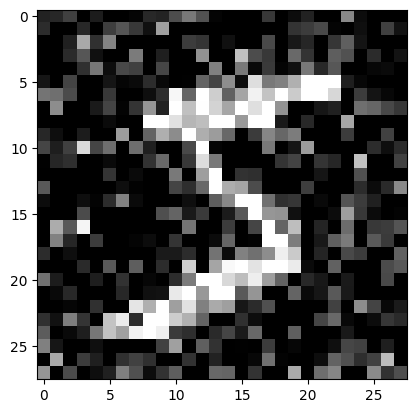

In [55]:
def add_gaussian_noise(image, mean=0, std=0.3):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    # Clip to valid range [0, 1] or [0, 255] depending on image format
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

noisy_img = add_gaussian_noise(x_train[0])
plt.imshow(noisy_img, cmap="gray")

In [56]:
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

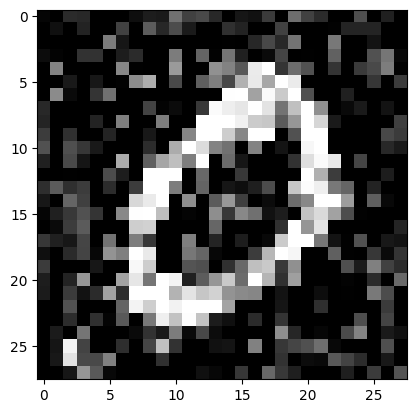

In [57]:
plt.imshow(x_train_noisy[1], cmap='gray')

In [58]:
x_train_noisy = np.expand_dims(x_train_noisy, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)


In [59]:
print(x_train_noisy[0].shape)

(28, 28, 1)


In [60]:
# inputs = keras.Input(shape=(28, 28, 1))
# x = layers.Flatten()(inputs)
# encoder_h1 = layers.Dense(512, actiavation='relu')(x)
# encoder_h1 = layers.Dense(256, activation='relu')(encoder_h1)
# latent_space = layers.Dense(128, activation='relu')(encoder_h2)

latent_dim = 128

input = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', padding='same',strides=2)(input)     #(14, 14, 32)
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)              #(7, 7, 64)
x = layers.Flatten()(x)
latent_space = layers.Dense(latent_dim, activation = 'relu')(x)

x = layers.Dense(7*7*64)(latent_space)     #(3136)
x = layers.Reshape((7, 7, 64))(x)           #(7, 7, 64)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=2)(x)        #(14, 14, 32)
output = layers.Conv2DTranspose(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same', strides=2)(x)        #(28, 28, 1)


autoencoder = keras.Model(inputs=input, outputs=output)



In [61]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=3,
        verbose=1,
        restore_best_weights=True
    )
]

# Train the autoencoder
autoencoder.fit(
    x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/30
938/938 [==============================] - 21s 11ms/step - loss: 0.1315 - accuracy: 0.8095 - val_loss: 0.0870 - val_accuracy: 0.8135
Epoch 2/30
938/938 [==============================] - 10s 11ms/step - loss: 0.0842 - accuracy: 0.8147 - val_loss: 0.0822 - val_accuracy: 0.8138
Epoch 3/30
938/938 [==============================] - 12s 13ms/step - loss: 0.0811 - accuracy: 0.8149 - val_loss: 0.0802 - val_accuracy: 0.8140
Epoch 4/30
938/938 [==============================] - 11s 12ms/step - loss: 0.0797 - accuracy: 0.8150 - val_loss: 0.0795 - val_accuracy: 0.8141
Epoch 4: early stopping


In [62]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


313/313 [==============================] - 1s 3ms/step


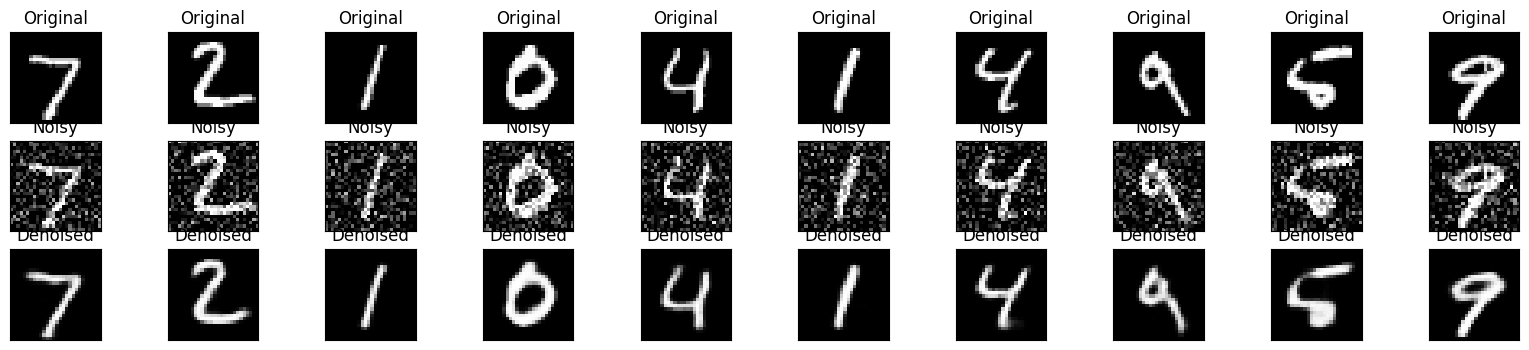

In [63]:
denoised_test_images = autoencoder.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()